In [ ]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [ ]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
#library(ComplexHeatmap)
library(pheatmap)
library(gplots)
library(svglite)
library(hdf5r)
library(DropletUtils)
library(scDblFinder)
library(scuttle)
library(scales)
library(ggrastr)

In [ ]:
library(future)
plan("multicore", workers = availableCores())
options(future.globals.maxSize= +Inf)
# NotebookApp.max_buffer_size=214748364800
# hello world

### File Loading and Saving Directories

In [4]:
load.dir <- '/oak/stanford/groups/agitler/Shared_Sequencing/Jacob/Levine-Human-FastQ/h5_files'
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

### Load H5 Matrices from Yadav 2022

In [ ]:
donor1_h5 <- Read10X_h5(paste(load.dir,'GSM5723843_Donor1_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor2_h5 <- Read10X_h5(paste(load.dir,'GSM5723844_Donor2_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor3_h5 <- Read10X_h5(paste(load.dir,'GSM5723845_Donor3_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor4_h5 <- Read10X_h5(paste(load.dir,'GSM5723846_Donor4_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor5_h5 <- Read10X_h5(paste(load.dir,'GSM5723847_Donor5_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor6_h5 <- Read10X_h5(paste(load.dir,'GSM5723848_Donor6_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor7_h5 <- Read10X_h5(paste(load.dir,'GSM5723849_Donor7_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)


In [6]:
bcrank1 <- barcodeRanks(donor1_h5)
bcrank2 <- barcodeRanks(donor2_h5)
bcrank3 <- barcodeRanks(donor3_h5)
bcrank4 <- barcodeRanks(donor4_h5)
bcrank5 <- barcodeRanks(donor5_h5)
bcrank6 <- barcodeRanks(donor6_h5)
bcrank7 <- barcodeRanks(donor7_h5)

In [7]:
debris_donor1 <- donor1_h5[,donor1_h5['NEFH', ] >1 & bcrank1$total<2000 & bcrank1$total>100]
donor1.debris.seurat <- CreateSeuratObject(debris_donor1)

In [8]:
debris_donor2 <- donor2_h5[,donor2_h5['NEFH', ] >1 & bcrank2$total<2000 & bcrank2$total>100]
donor2.debris.seurat <- CreateSeuratObject(debris_donor2)

In [9]:
debris_donor3 <- donor3_h5[,donor3_h5['NEFH', ] >1 & bcrank3$total<2000 & bcrank3$total>100]
donor3.debris.seurat <- CreateSeuratObject(debris_donor3)

In [10]:
debris_donor4 <- donor4_h5[,donor4_h5['NEFH', ] >1 & bcrank4$total<2000 & bcrank4$total>100]
donor4.debris.seurat <- CreateSeuratObject(debris_donor4)

In [11]:
debris_donor5 <- donor5_h5[,donor5_h5['NEFH', ] >1 & bcrank5$total<2000 & bcrank5$total>100]
donor5.debris.seurat <- CreateSeuratObject(debris_donor5)

In [12]:
debris_donor6 <- donor6_h5[,donor6_h5['NEFH', ] >1 & bcrank6$total<2000 & bcrank6$total>100]
donor6.debris.seurat <- CreateSeuratObject(debris_donor6)

In [13]:
debris_donor7 <- donor7_h5[,donor7_h5['NEFH', ] >1 & bcrank7$total<2000 & bcrank7$total>100]
donor7.debris.seurat <- CreateSeuratObject(debris_donor7)

### Log Normalize list of Seurat Objects

In [14]:
normalize.aggregated.object <- function(experiment.aggregate) {
    library(Seurat)
    library(future)
    print("splitting complete")
    for (i in 1:length(x = experiment.aggregate)) {
        print(i)
        experiment.aggregate[[i]] <- NormalizeData(object = experiment.aggregate[[i]], 
            verbose = TRUE)
        print("normalization complete")
        experiment.aggregate[[i]] <- FindVariableFeatures(object = experiment.aggregate[[i]], 
            selection.method = "vst", nfeatures = 2000, verbose = TRUE)
        print("variable feature selection complete")
    }
    experiment.aggregate
}

In [15]:
find.pcs.and.clustids <- function (exp.data, pc.dims = 30, scale.data = TRUE, feature.list = NULL) 
{
    library(future)
    library(doParallel)
    if (scale.data == TRUE) {
        exp.data <- ScaleData(object = exp.data, verbose = TRUE)
    }
    exp.data <- RunPCA(object = exp.data, npcs = pc.dims, verbose = TRUE, 
        features = feature.list)
    exp.data <- RunUMAP(object = exp.data, reduction = "pca", 
        dims = 1:pc.dims)
    exp.data <- FindNeighbors(exp.data, dims = 1:pc.dims)
    exp.data <- FindClusters(exp.data, resolution = 0.5)
    exp.data
}

In [ ]:
debris.objects.list <- c(donor1.debris.seurat, donor2.debris.seurat, donor3.debris.seurat, donor4.debris.seurat, donor5.debris.seurat, donor6.debris.seurat, donor7.debris.seurat)
debris.objects.list.normalized <- normalize.aggregated.object(debris.objects.list)

### Remove Mitochondrial Reads

In [17]:
for(i in 1:length(debris.objects.list.normalized)) {
    counts <- GetAssayData(debris.objects.list.normalized[[i]], assay = "RNA")
    mito_genes <- grep( "^MT-", rownames(debris.objects.list.normalized[[i]]), value = T)
    counts <- counts[-(which(rownames(counts) %in% mito_genes)),]
    debris.objects.list.normalized[[i]] <- subset(debris.objects.list.normalized[[i]], features = rownames(counts))
    
}

### Find Variable Features etc

In [ ]:
for(i in 1:length(debris.objects.list.normalized)) {
    DefaultAssay(debris.objects.list.normalized[[i]]) <- 'RNA'
    debris.objects.list.normalized[[i]] <- FindVariableFeatures(debris.objects.list.normalized[[i]])
    debris.objects.list.normalized[[i]] <- find.pcs.and.clustids(debris.objects.list.normalized[[i]])
    
}

### Integrate Across Datasets

In [ ]:
debris.droplets.anchors <- FindIntegrationAnchors(object.list = debris.objects.list.normalized, )


In [ ]:
debris.droplets.integrated <- IntegrateData(anchorset = debris.droplets.anchors, verbose=T)


In [ ]:
DefaultAssay(debris.droplets.integrated) <- 'RNA'
debris.droplets.integrated <- FindVariableFeatures(debris.droplets.integrated)
debris.droplets.integrated <- find.pcs.and.clustids(debris.droplets.integrated)

### Based on expression of NEAT1 and NEFM, Clusters 2, 3, and 5 are neuronal debris

In [23]:
DefaultAssay(debris.droplets.integrated) <- 'integrated'
debris.droplets.integrated.final <- subset(debris.droplets.integrated, idents=c(2,3,5))

In [ ]:
DefaultAssay(debris.droplets.integrated) <- 'RNA'
debris.droplets.integrated.final <- FindVariableFeatures(debris.droplets.integrated.final)
debris.droplets.integrated.final <- find.pcs.and.clustids(debris.droplets.integrated.final)

### Based on reclustering and NEAT1/NEFM expression, clusters 0,1,2 are neuronal debris

In [25]:
DefaultAssay(debris.droplets.integrated.final) <- 'integrated'
debris.droplets.integrated.neuronal <- subset(debris.droplets.integrated.final, idents=c(0,1,2))

In [ ]:
debris.droplets.integrated.neuronal <- FindVariableFeatures(debris.droplets.integrated.neuronal)
debris.droplets.integrated.neuronal <- RunPCA(debris.droplets.integrated.neuronal)


In [ ]:
debris.droplets.integrated.neuronal <- FindNeighbors(debris.droplets.integrated.neuronal, dims = 1:20)
debris.droplets.integrated.neuronal <- FindClusters(debris.droplets.integrated.neuronal, resolution = 2)

In [ ]:
debris.droplets.integrated.neuronal <- RunUMAP(debris.droplets.integrated.neuronal, dims = 1:20)

In [29]:
neuronal_debris_umap <- DimPlot(debris.droplets.integrated.neuronal, label=T, raster = F, pt.size = 1.5)  + NoLegend()
neuronal_debris_umap <- rasterize(neuronal_debris_umap, layers='Point', dpi=500)
ggsave(filename = paste(fig_dir,'neuronal_debris_umap.svg', sep='/'),
       plot= neuronal_debris_umap, device = 'svg')

Saving 6.67 x 6.67 in image



## Supplementary Figure S1e

In [30]:
DefaultAssay(debris.droplets.integrated.neuronal) <- 'RNA'

neuronal_debris_featureplot <- FeaturePlot(debris.droplets.integrated.neuronal, pt.size = 1,
                                          features=c('SLC17A6', 'SLC6A5', 'SLC5A7', 'GAD1'), label=T) 
neuronal_debris_featureplot <- rasterize(neuronal_debris_featureplot, layers='Point', dpi=500)

ggsave(filename = paste(fig_dir,'neuronal_debris_featureplot.svg', sep='/'),
       plot= neuronal_debris_featureplot, device = 'svg')

Saving 6.67 x 6.67 in image



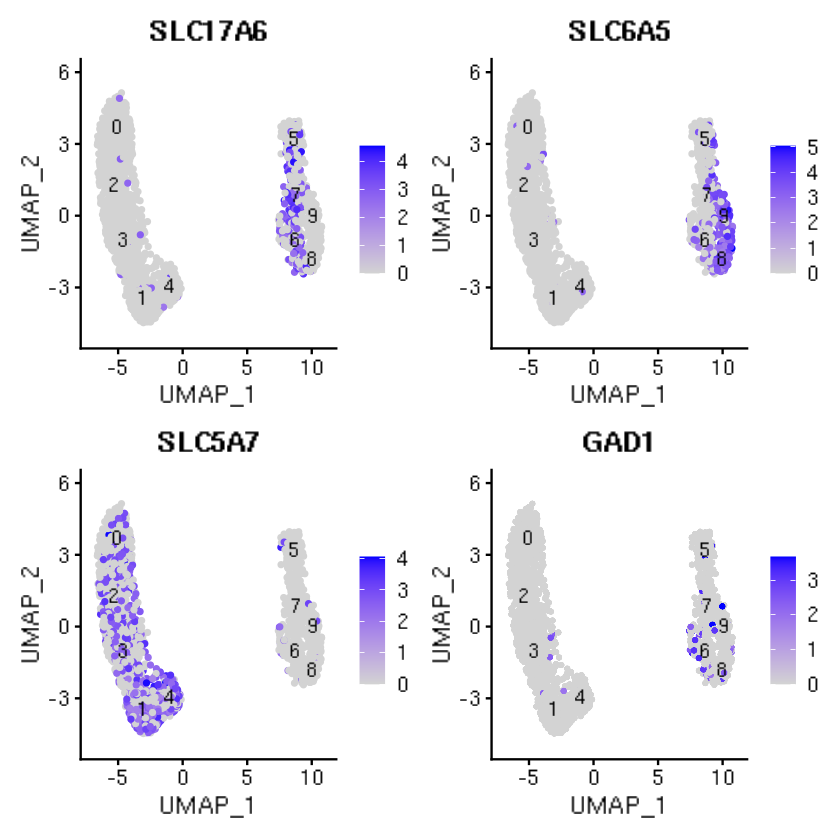

In [31]:
neuronal_debris_featureplot

## Supplementary Figure S1F


In [33]:
neuronal_debris.exp.mat <- AverageExpression(debris.droplets.integrated.neuronal, assays = 'RNA')$RNA

In [34]:
marker.heatmap <- neuronal_debris.exp.mat[c('SLC5A7', 'SLC17A6', 
                                    'SLC6A5', 'GAD1', 'ACLY','GAD2'),]

In [35]:
marker.heatmap <- (marker.heatmap - rowMins(marker.heatmap))/(rowMaxs(marker.heatmap) - rowMins(marker.heatmap))

In [36]:
colnames(marker.heatmap) <- paste('Cluster', colnames(marker.heatmap), sep=' ')

In [37]:
neuronal_debris_subclustering_heatmap <- 
    pheatmap(marker.heatmap, cluster_rows = TRUE, cluster_cols = TRUE, 
             filename = paste(fig_dir, 'neuronal_debris_subclustering_heatmap.pdf', sep='/'), 
             width = 6.4, height = 5.5, fontsize = 14) 

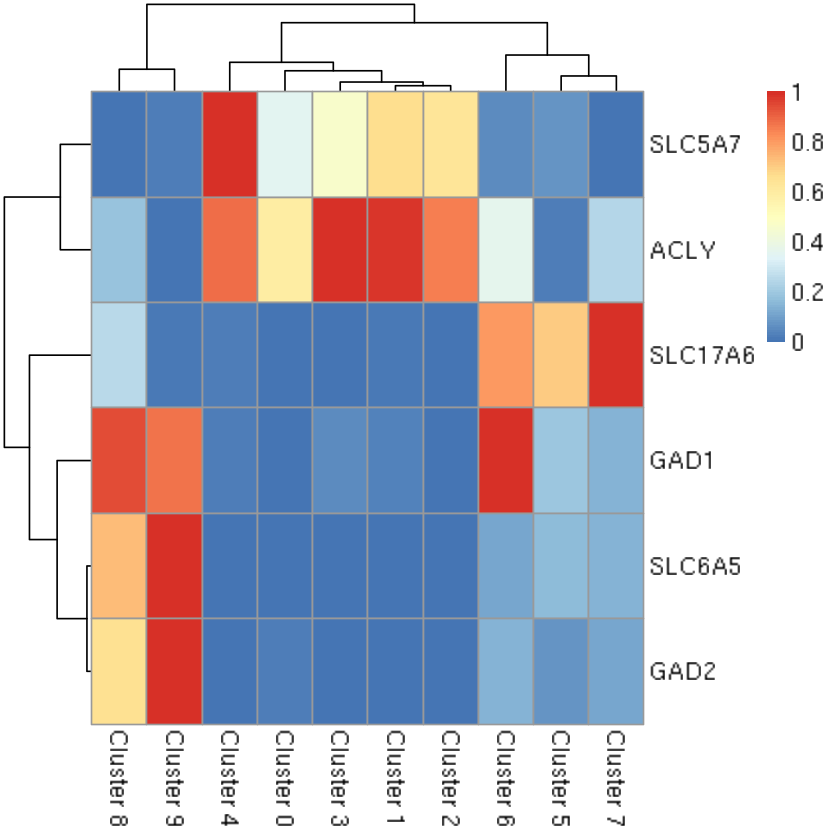

In [38]:
neuronal_debris_subclustering_heatmap

## Supplementary Figure S1G

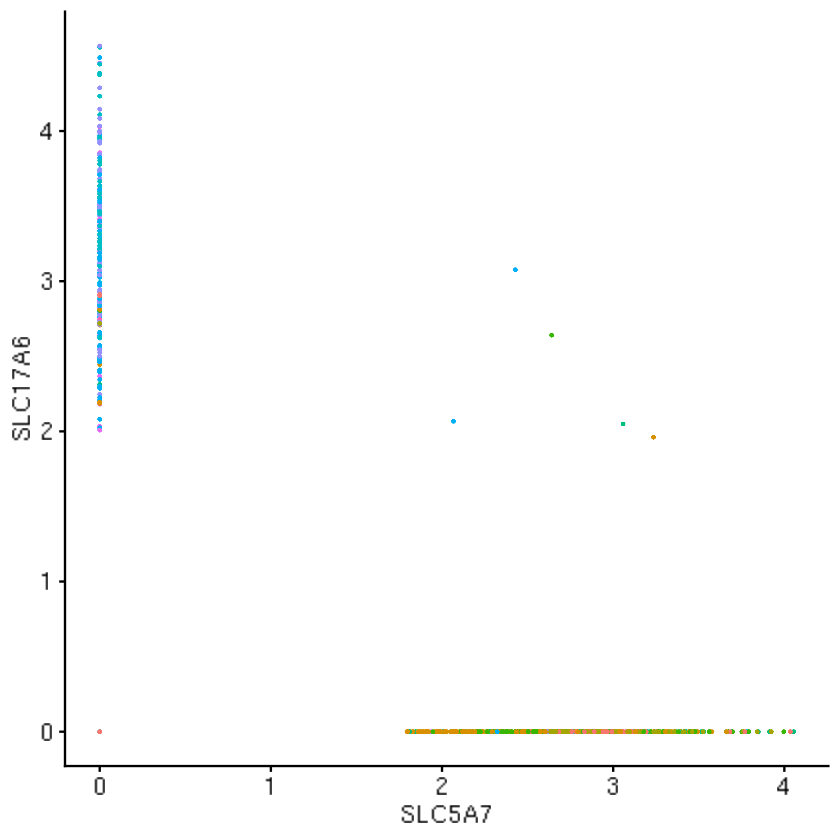

In [39]:
cholinergic_glutamatergic_scatter <- FeatureScatter(debris.droplets.integrated.neuronal, pt.size=0.5, feature1=c('SLC5A7'), feature2='SLC17A6')
cholinergic_glutamatergic_scatter <- rasterize(cholinergic_glutamatergic_scatter, layer= 'Point', dpi=500) + 
    NoLegend() + FontSize(x.title=14, y.title=14, x.text=14, y.text=14) + theme(plot.title=element_blank())

cholinergic_glutamatergic_scatter

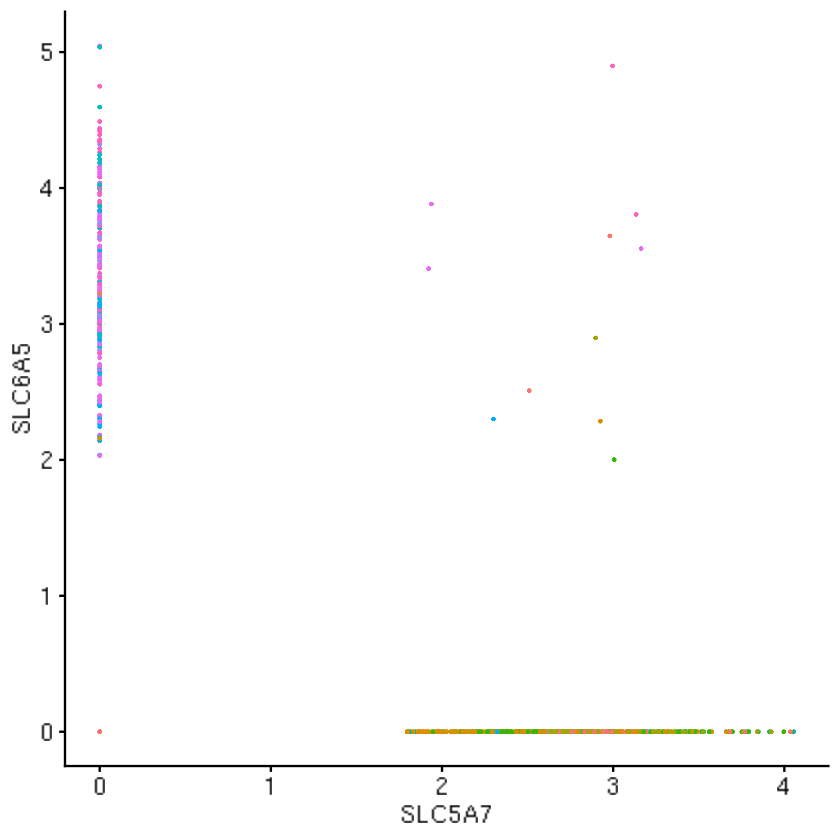

In [40]:
cholinergic_glycinergic_scatter <- FeatureScatter(debris.droplets.integrated.neuronal, pt.size = 0.5, feature1=c('SLC5A7'), feature2='SLC6A5')
cholinergic_glycinergic_scatter <- rasterize(cholinergic_glycinergic_scatter, layer= 'Point', dpi=500) + 
    NoLegend() + FontSize(x.title=14, y.title=14, x.text=14, y.text=14) + theme(plot.title=element_blank())

cholinergic_glycinergic_scatter

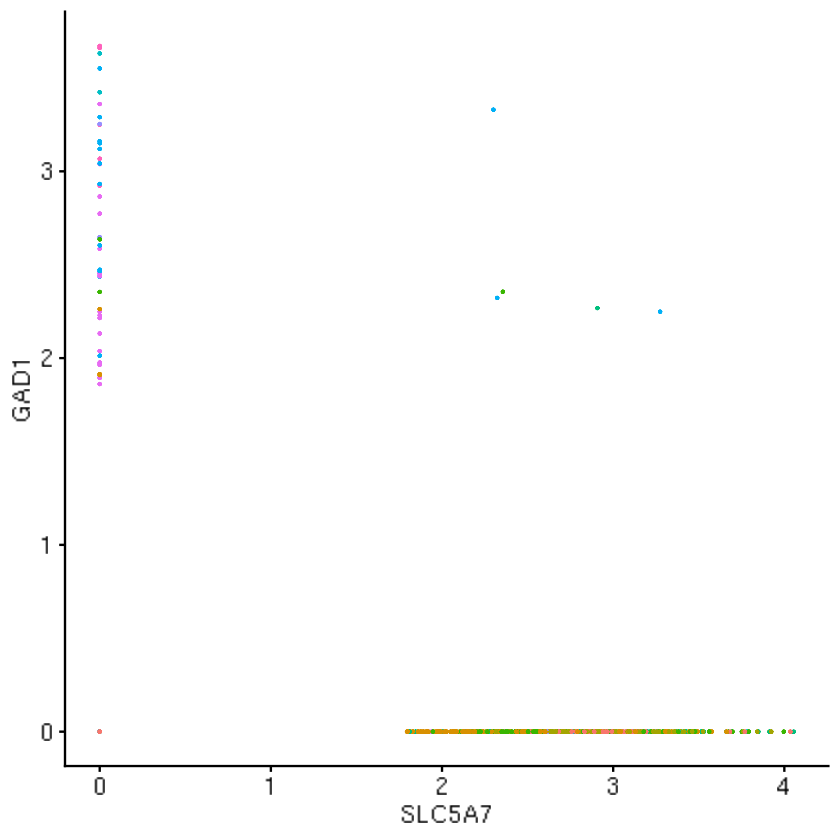

In [42]:
cholinergic_gabaergic_scatter <- FeatureScatter(debris.droplets.integrated.neuronal, pt.size=0.5, feature1=c('SLC5A7'), feature2='GAD1')
cholinergic_gabaergic_scatter <- rasterize(cholinergic_gabaergic_scatter, layer= 'Point', dpi=500) +
    NoLegend() + FontSize(x.title=14, y.title=14, x.text=14, y.text=14) + theme(plot.title=element_blank())

cholinergic_gabaergic_scatter

In [ ]:
ggsave(filename = paste(fig_dir,'cholinergic_glutamatergic_scatter.svg', sep='/'),
       plot= cholinergic_glutamatergic_scatter, device = 'svg', width=2, height=2, unit= 'in')

In [ ]:
ggsave(filename = paste(fig_dir,'cholinergic_glycinergic_scatter.svg', sep='/'),
       plot= cholinergic_glycinergic_scatter, device = 'svg', width=2, height=2, unit= 'in')

In [ ]:
ggsave(filename = paste(fig_dir,'cholinergic_gabaergic_scatter.svg', sep='/'),
       plot= cholinergic_gabaergic_scatter, device = 'svg', width=2, height=2, unit= 'in')

In [ ]:
saveRDS(debris.droplets.integrated.neuronal, file= '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/debris_droplets_integrated_neuronal.RDS')


In [ ]:
debris.droplets.integrated.neuronal <- readRDS(file= '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/debris_droplets_integrated_neuronal.RDS')


In [ ]:
debris.droplets.integrated.neuronal